## Load and prepare the data

The first step is to load the dataset and prepare it for use in machine learning. Because machine-learning models can't deal with text, we'll use scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class to vectorize the training text. Then we'll split the data for training and testing.

In [1]:
import pandas as pd

df = pd.read_csv('Data/reviews.csv', encoding="ISO-8859-1")
df.head()

,Text,Sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


Find out how many rows the dataset contains and confirm that there are no missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       50000 non-null  object
 1   Sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


Check for duplicate rows in the dataset.

In [3]:
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          25000  24697  This show comes up with interesting locations ...   
1          25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
Sentiment       
0            3  
1            5

The dataset contains a few hundred duplicate rows. Let's remove them and check for balance.

In [4]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  I am a huge fan of the first four Ju-on projec...   
1          24884  24884  Probably the first Portuguese film I have seen...   

                
          freq  
Sentiment       
0            1  
1            1

Use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to vectorize the text in the DataFrame's "Text" column using a built-in dictionary of stop words. Set `min_df` to 20 to ignore words that appear less than 20 times in the corpus of training text. This will reduce the likelihood of out-of-memory errors and will probably make the model more accurate as well.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=20)
x = vectorizer.fit_transform(df['Text'])
y = df['Sentiment']

In addition to creating sparse matrices of vectorized text, `Countvectorizer` converts text to lowercase, removes stop words and punctuation characters, and more. Let's see how it cleans text before vectorizing it by transforming a string, and then reversing the transform.

In [6]:
text = vectorizer.transform(['The long l3ines   and; pOOr customer# service really turned me off...123.'])
text = vectorizer.inverse_transform(text)
print(text)

[array(['customer', 'long', 'poor', 'really', 'service', 'turned'],
      dtype='<U25')]


Split the dataset for training and testing. We'll do a 50/50 split since the dataset contains nearly 50,000 samples.

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)  

## Train a logistic-regression model

The next step is to train a classifier. We'll use scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, which uses [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) to fit a model to the data.

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

Validate the trained model with the 50% of the dataset aside for testing and show a confusion matrix.

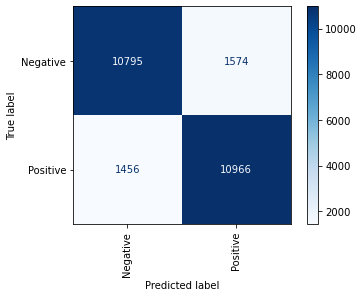

In [9]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, x_test, y_test, display_labels=['Negative', 'Positive'], cmap='Blues', xticks_rotation='vertical')

The model correctly identified 10,795 negative reviews while misclassifying 1,574 of them. It correctly identified 10,966 positive reviews and got it wrong 1,456 times. Use the `score` method to get a rough measure of the model's accuracy.

In [10]:
model.score(x_test, y_test)

0.8777782259691017

Now retrieve the Receiver Operating Characteristic (ROC) metric for a better measure of accuracy.

In [11]:
from sklearn.metrics import roc_auc_score

probabilities = model.predict_proba(x_test)
roc_auc_score(y_test, probabilities[:, 1])

0.9451464160372365

## Use the model to analyze text

Let's score a review by vectorizing the text of that review and passing it to the model's `predict_proba` method. Are the results consistent with what you would expect?

In [12]:
review = 'The long lines and poor customer service really turned me off.'
model.predict_proba(vectorizer.transform([review]))[0][1]

0.09183512790552076

Now score a more positive review and see if the model agrees that the sentiment is positive.

In [13]:
review = 'One of the more delightful experiences I have had!'
model.predict_proba(vectorizer.transform([review]))[0][1]

0.6955088233953494

Finish up by saving the model and its vocabulary.

In [14]:
import pickle

pickle.dump(model, open('Data/sentiment.pkl', 'wb'))
pickle.dump(vectorizer.vocabulary_, open('Data/vocabulary.pkl', 'wb'))